# Introduction

"Have you tried looking at the waveforms from those events?"  - David Radford

This is a tutorial demonstrating several ways to use the Waveform browser to examine data from LEGEND. This will consist of multiple examples, increasing in complexity, and will use data from the PGT. The waveform browser (pygama.dsp.WaveformBrowser) is a pygama utility for accessing waveforms from raw files in an interactive way, enabling you to access, draw, or even process waveforms. Some use cases for this utility include investigating a population of waveforms, and debugging waveform processors.

Why do we need a waveform browser when we can access data via pandas dataframes?
Pandas dataframes work extremely well for reading tables of simple values from multiple HDF5 files. However, they are less optimal for waveforms. The reason for this is that they require holding all waveforms in memory at once. If we want to look at waveforms spread out across multiple files, this can potentially take up GBs of memory, which will cause problems! To get around this, we want to load only bits of the files into memory at a time and pull out only what we need. Since this is an inconvenient process, the WaveformBrowser will do this for you, while hiding the details as much as possible.

## Contents:
**Example 1:** Minimal usage of the waveform browser  
**Example 2:** Draw waveforms using a data cut to investigate a population; fill a legend  
**Example 3:** Draw waveforms from multiple populations with different cuts for comparison; using more advanced formatting options  
**Example 4:** Draw processed waveforms from a DSP config file to inspect processors  
**Example 5:** Access waveforms without drawing

In [9]:
#First, import necessary modules and set some input values for use later
%matplotlib inline
import pygama.io.lh5 as lh5
from pygama.dsp.WaveformBrowser import WaveformBrowser
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json

# Set input values for where to find our data. This will grab all calibration runs from run 30, parsing wildcards
pgt_dir = '$LEGENDDATADIR/lngs/pgt/'
raw_files = pgt_dir + 'raw/geds/LPGTA_r0030_*_calib_geds_raw.lh5'
dsp_files = pgt_dir + 'dsp/geds/LPGTA_r0030_*_calib_geds_dsp.lh5'
channel = 'g040'

# Set defaults for figures
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
print(dsp_files)

$LEGENDDATADIR/lngs/pgt/dsp/geds/LPGTA_r0030_*_calib_geds_dsp.lh5


## Example 1

First, a minimal example simply drawing waveforms from the raw file

Processing parameters: []
Required input parameters: []
Copied output parameters: ['waveform']
Processed output parameters: []


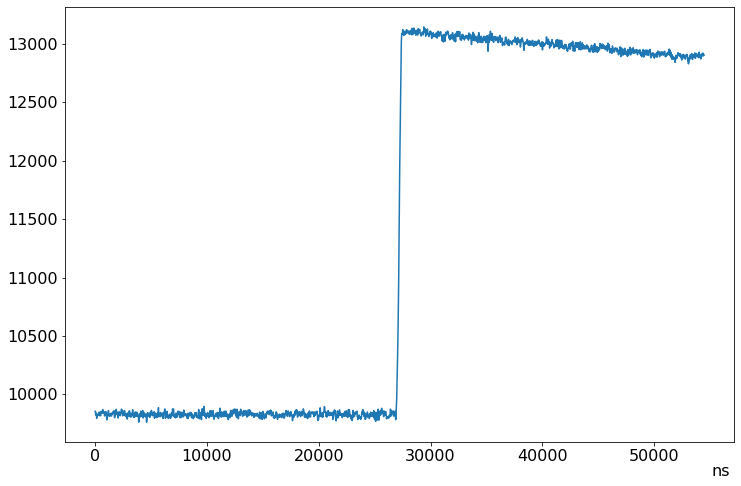

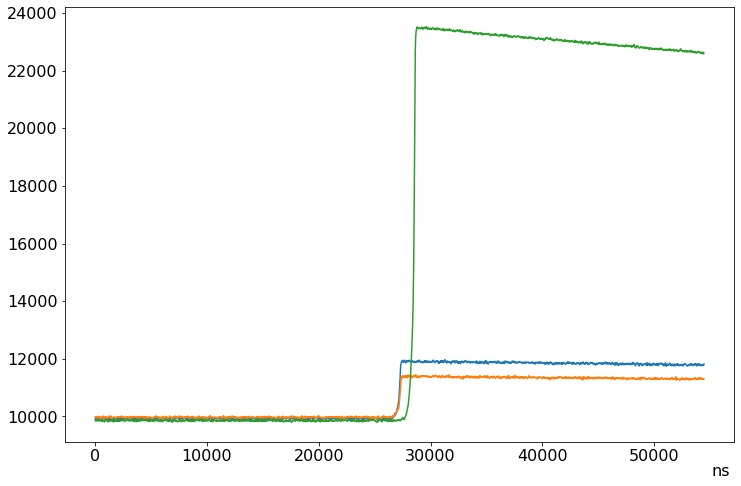

In [2]:
# Create a minimal waveform browser; a file or list of files is required
browser = WaveformBrowser(raw_files, channel+'/raw')

# Draw the 100th waveform in the file
browser.draw_entry(100)

# To draw multiple figures in a single cell, you must explicitly create a new one:
browser.new_figure()
browser.draw_entry([200, 300, 400])

[5]

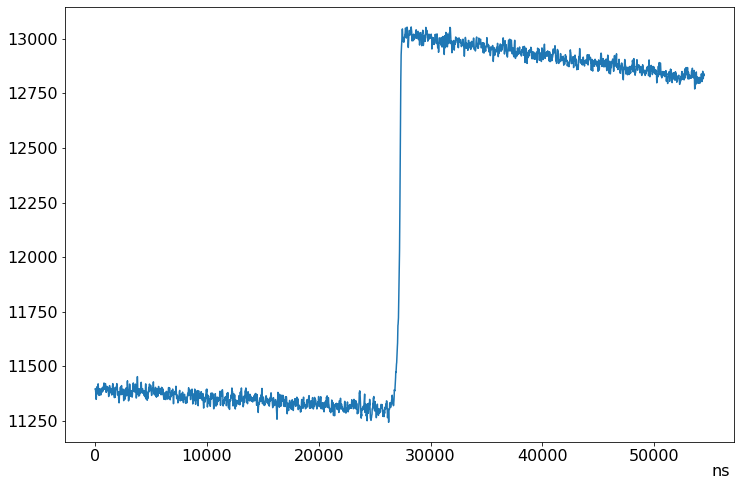

In [8]:
# Draw the next waveform in the file. You can run this cell multiple times to scroll through many WFs
browser.draw_next()

## Example 2
Ok, that was nice, but how often do we just want to scroll through all of our waveforms?

For our next example, we will select a population of waveforms from within the files, and draw multiple at once. Selecting a population of events to draw uses the same syntax as numpy and pandas, and can be done either with a list of entries or a boolean numpy array. This selection can be made using data from a dsp or hit hit file.

We will also learn how to set a few other properties of the figure

In [10]:
# First, load a dataframe from a DSP file that we can use to make our selection:
df = lh5.load_dfs(dsp_files, ['trapE', 'AoE'], channel+'/dsp')

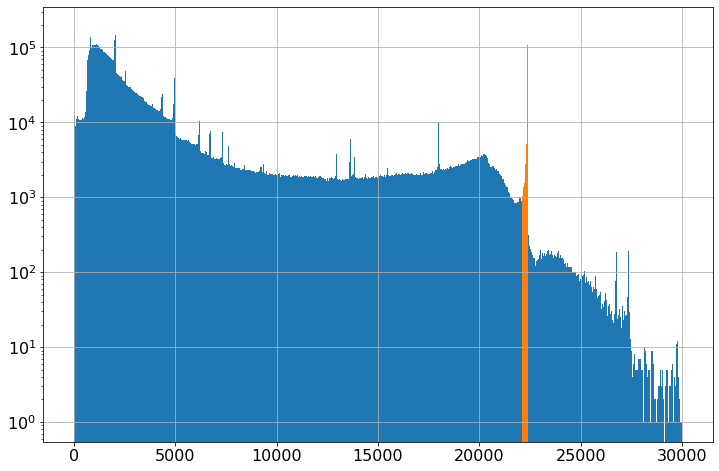

In [11]:
# Create a selection mask around the 2614 keV peak
trapE = df['trapE']
energy_selection = (trapE>22100) & (trapE<22400)

trapE.hist(bins=1000, range=(0, 30000))
trapE[energy_selection].hist(bins=1000, range=(0, 30000))
plt.yscale('log')

Entries: [6, 14, 43, 129, 343, 376, 402, 500, 534, 564]
Entries: [570, 622, 684, 736, 772, 946, 948, 1011, 1072, 1123]
Entries: [1204, 1224, 1230, 1278, 1286, 1353, 1359, 1434, 1469, 1522]
Entries: [1546, 1587, 1599, 1612, 1693, 1791, 1796, 1892, 1915, 1961]
Entries: [2042, 2075, 2080, 2152, 2314, 2361, 2401, 2411, 2447, 2487]


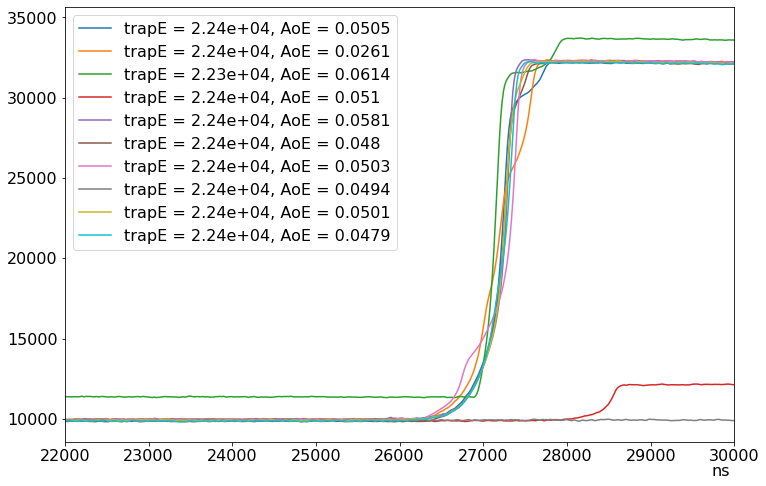

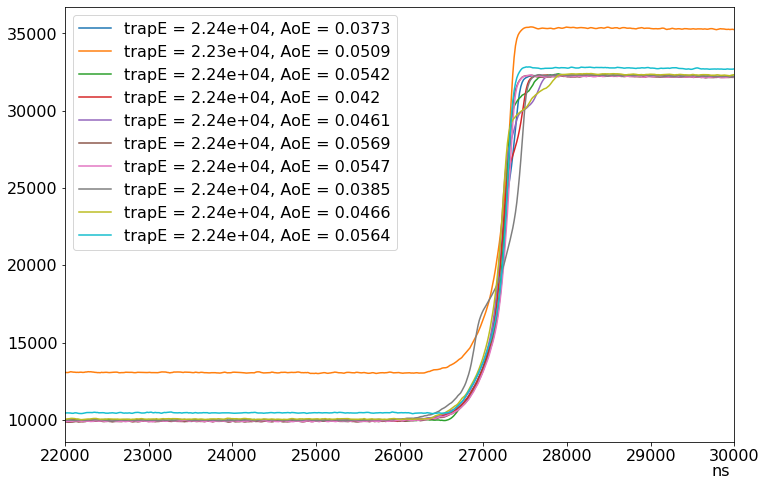

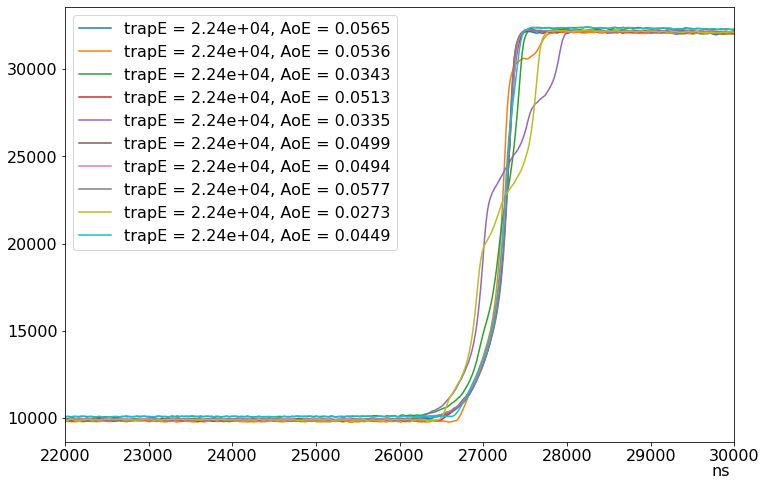

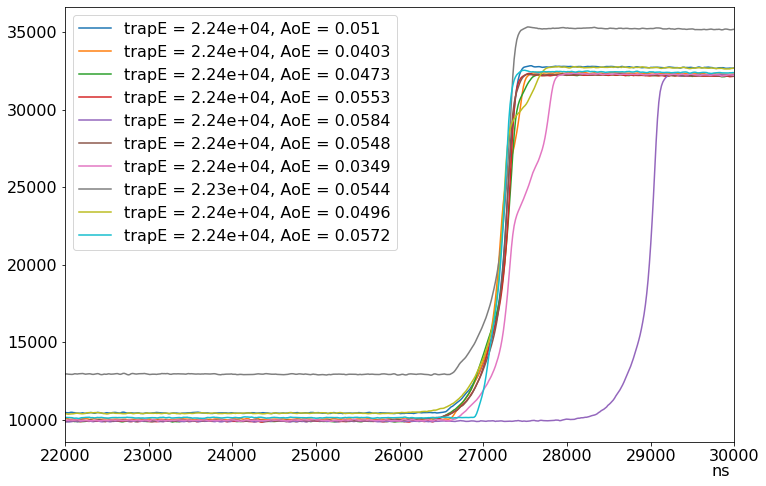

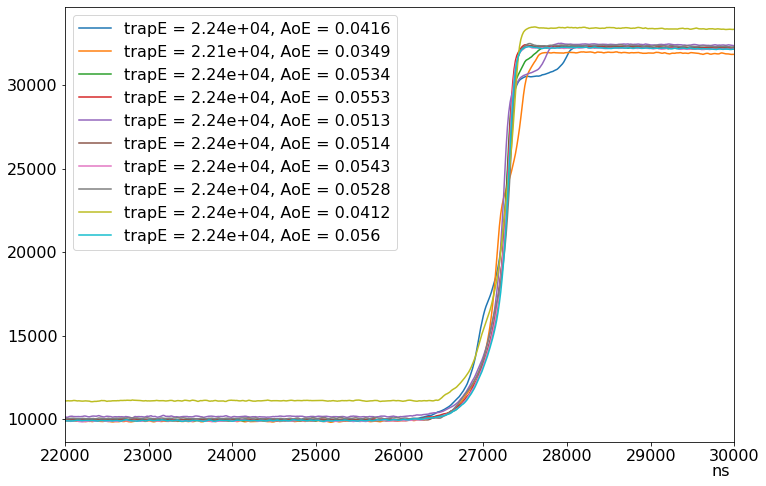

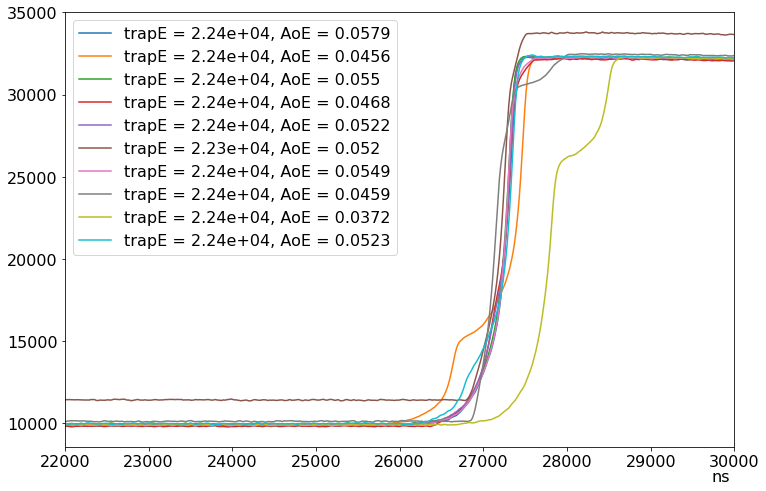

In [5]:
# Now construct a WaveformBrowser with this cut
browser = WaveformBrowser(raw_files, channel+'/raw',
                          verbosity   = 0,                  # Silence output on construction
                          legend      = (trapE, df['AoE']), # Values to put in the legend
                          x_lim       = (22000, 30000),     # Range for time-axis
                          selection   = energy_selection ,  # Apply cut
                          n_drawn     = 10                  # number to draw for draw_next
                         )

# Draw the next 5 batches of 10 waveforms, and move the legend outside
for entries, i in zip(browser, range(5)):
    print("Entries:", entries)
    browser.new_figure()
    #plt.pause(1) # If you can use interactive plots (i.e. not on nersc), you can comment the above line and uncomment this one to draw a slideshow!


## Example 3
Lets take it a step further: this time, lets draw waveforms from multiple populations for the sake of comparison. This will require creating two separate waveform browsers and drawing them onto the same axes. We'll also normalization of the waveforms. Finally, we'll add some formatting options to the lines and legend.

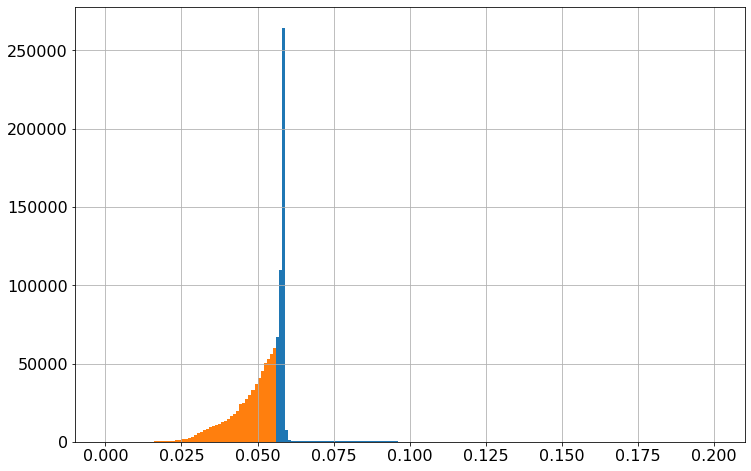

In [6]:
AoE = df['AoE']
energy_cut = (trapE>10000)
aoe_cut = (AoE<0.056) & energy_cut
aoe_accept = (AoE>0.056) & energy_cut

AoE[energy_cut].hist(bins=200, range=(-0, 0.2))
AoE[aoe_cut].hist(bins=200, range=(-0, 0.2))

In [7]:
browser1 = WaveformBrowser(raw_files, channel+'/raw',
                           verbosity   = 0,                 # Silence output on construction
                           wf_styles   = {'color':['red', 'orange', 'salmon', 'darkorange', 'maroon']}, # set a color cycle for this
                           legend      = ("E={:.0f} ADC, A/E={:.3f}", trapE, AoE), # Formatted values to put in the legend
                           norm        = trapE,             # Normalize waveforms by energy
                           selection   = aoe_cut,           # Apply cut
                           n_drawn     = 5                  # number to draw for draw_next
                          )

browser2 = WaveformBrowser(raw_files, channel+'/raw',
                           verbosity = 0,                 # Silence output on construction
                           wf_styles = {'color':['blue', 'purple', 'cyan', 'violet', 'indigo']}, # set a color cycle for this
                           legend    = ("E={:.0f} ADC, A/E={:.3f}", trapE, AoE), # Formatted values to put in the legend
                           legend_opts = {'loc':"center",'bbox_to_anchor':(1,0.35)}, # set options for drawing the legend
                           norm      = trapE,             # Normalize waveforms by energy
                           x_lim     = (25000, 30000),    # Range for time-axis
                           selection = aoe_accept,           # Apply cut
                           n_drawn   = 5                  # number to draw for draw_next
                          )

[22, 43, 47, 68, 161]

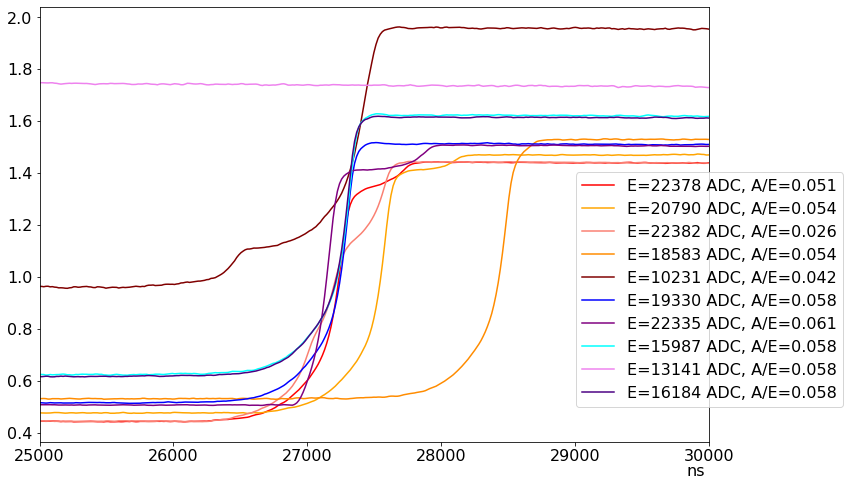

In [8]:
browser1.draw_next()
browser2.set_figure(browser1) # use the same figure/axis as the other browser
browser2.draw_next(clear=False) # Set clear to false to draw on the same axis!

## Example 4
Now, we'll shift from drawing populations of waveforms to drawing waveform transforms. We can draw any waveforms that are defined in a DSP JSON configuration file. This is useful for debugging purposes and for developing processors. We will draw the baseline subtracted WF, pole-zero corrected WF, and trapezoidal filter WF. We will also draw horizontal and vertical lines for trapE (the max of the trapezoid) and tp_0 (our estimate of the start of the waveform's rise). The browser will determine whether these lines should be horizontal or vertical based on the unit.

In [9]:
# Use the lpgta dsp json file. TODO: get this from DataGroup
dsp_config_file = os.path.expandvars("$HOME/pygama/experiments/lpgta/LPGTA_dsp.json")


In [10]:
browser = WaveformBrowser(raw_files, channel+'/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pz', 'wf_trap'], # names of waveforms from dsp config file
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected', "Trap (max={trapE:.0f})"],
                          legend_opts={'loc':"upper left"},
                          lines=['trapE', 'tp_0'], # add hlines and vlines
                          x_lim=(15000, 55000) # x axis range
                         )

Processing parameters: ['bl, bl_sig', 'wf_blsub', 'wf_pz', 'wf_trap', 'trapE', 'wf_atrap', 'tp_max', 'tp_0']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz', 'wf_trap', 'trapE', 'tp_0']
Database lookup: found 396.9*us for db.pz_const


[0]

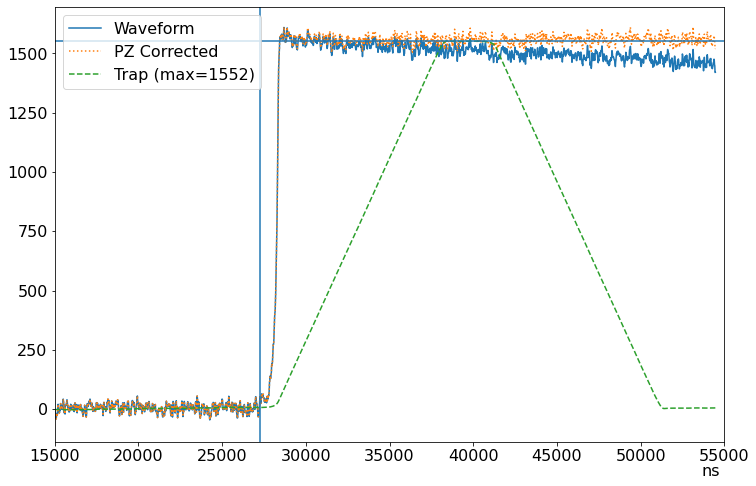

In [19]:
browser.draw_next()

## Example 5
Sometimes you just want to access the waveforms without drawing them. There can be many reasons for this: maybe you want to try processing them with a function that isn't part of the pygama dsp framework yet. Maybe the drawing options provided aren't right for you. Either way, if you need more control over what happens with waveforms, it is possible to directly and quickly access them through the waveform browser.

The waveforms are stored in the class as a list of lists of pairs of numpy arrays. The outer list is across the waveforms we have requested. The inner list contains the number of waveforms we have requested. Each waveform is stored as a tuple pair of (time, waveform)

When accessing waveforms in this way, you can also do the same things previously shown, such as applying a data cut and grabbing processed waveforms. For this example, we are going to get waveforms and trap-waveforms that pass the A/E cut. We will simply print them, but the possibility exists to do whatever we want!

In [11]:
browser = WaveformBrowser(raw_files, channel+'/raw', dsp_config_file, # Need to include a dsp config file!
                          database  = {"pz_const":'396.9*us'},        # TODO: use metadata instead of manually defining...
                          waveforms = ['waveform', 'wf_trap'],        # names of waveforms from dsp config file
                          selection = aoe_accept,                     # apply A/E cut
                          n_drawn   = 5                               # get two at a time
                         )

Processing parameters: ['bl, bl_sig', 'wf_blsub', 'wf_pz', 'wf_trap']
Required input parameters: ['waveform']
Copied output parameters: ['waveform']
Processed output parameters: ['wf_trap']
Database lookup: found 396.9*us for db.pz_const


In [12]:
browser.find_next()
waveforms = browser.wf_data[0]
traps = browser.wf_data[1]
for wf, trap in zip(waveforms, traps):
    print("Raw waveform:", wf[1])
    print("Trap-filtered waveform", trap[1], '\n')

Raw waveform: [ 9961.  9961.  9962. ... 28042. 28045. 28033.]
Trap-filtered waveform [ -0.05395781  -0.1079178   -0.16027996 ... -13.000887   -12.998912
 -13.000124  ] 

Raw waveform: [11433. 11433. 11433. ... 32151. 32152. 32165.]
Trap-filtered waveform [ 1.8529687e-02  3.7060123e-02  5.5591308e-02 ... -5.7785522e+01
 -5.7699192e+01 -5.7577663e+01] 

Raw waveform: [ 9988.  9988. 10000. ... 24927. 24927. 24925.]
Trap-filtered waveform [ -0.03714219  -0.07428587  -0.09223106 ... -11.408537   -11.469424
 -11.503114  ] 

Raw waveform: [ 9996.  9996.  9983. ... 22018. 22018. 22002.]
Trap-filtered waveform [ 0.05984687  0.11969616  0.15874787 ... -8.23342    -8.190882
 -8.167535  ] 

Raw waveform: [10016. 10016. 10025. ... 25124. 25127. 25136.]
Trap-filtered waveform [-1.0154688e-02 -2.0309785e-02 -1.6065292e-02 ... -1.6330290e+01
 -1.6301731e+01 -1.6261971e+01] 

